In [ ]:
!pip install pandahouse -q

  Preparing metadata (setup.py) ... done


In [ ]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')


In [ ]:
def select(sql):
    return ph.read_clickhouse(sql, connection=connection)

# Task 1
Ваш менее опытный коллега не уверен, что его таблица retail действительно создалась и добавилась в базу данных. Напишите запрос, который создаст таблицу, если она еще не существует (IF NOT EXISTS), со следующими параметрами:

Название: retail
База: test
Столбцы:
- InvoiceNo – идентификатор заказа, строковое значение

- StockCode – идентификатор товара, строковое значение

- Description – описание товара, строковое значение

- Quantity – количество единиц товара, добавленных в корзину (особенность данных – значения могут быть отрицательными, 32 бита)

- InvoiceDate – дата и время создания заказа (транзакции), часовой пояс – 'Europe/London'

- UnitPrice – цена за единицу товара (особенность данных – значения могут быть отрицательными, точность – три знака после точки, 64 бита)

- CustomerID – идентификатор пользователя, целое положительное число, 32 бита.

- Country – страна, строковое значение. 

Движок: MergeTree
Сортировка: InvoiceDate, CustomerID


In [ ]:
sql = '''CREATE TABLE IF NOT EXISTS test.retail ( 
    InvoiceNo String,
    StockCode String,
    Description String,
    Quantity Int32,
    InvoiceDate DateTime('Europe/London'),
    UnitPrice Decimal64(3),
    CustomerID UInt32,
    Country String
   ) 

ENGINE = MergeTree
ORDER BY (InvoiceDate, CustomerID)'''

# Task 3
Для начала посмотрите, в каких странах имеется наибольшее число уникальных пользователей. Постройте барчарт, где:

по оси x – страна
по оси y – число пользователей
В качестве ответа укажите число уникальных пользователей из Великобритании. 

Note: запятые в Redash отделяют каждые три знака в числе (тысячные доли, миллионные и так далее). Например, 2,535,966 - это 2535966. В ответ надо писать число без запятых.

In [ ]:
sql = '''SELECT
    count(distinct(CustomerID)) as customers,
    Country
from
    retail
group by Country
order by customers desc'''

In [ ]:
countries = select(sql)
countries.head()

,customers,Country
0,3950,United Kingdom
1,95,Germany
2,87,France
3,31,Spain
4,25,Belgium


<Figure size 1200x1000 with 0 Axes>

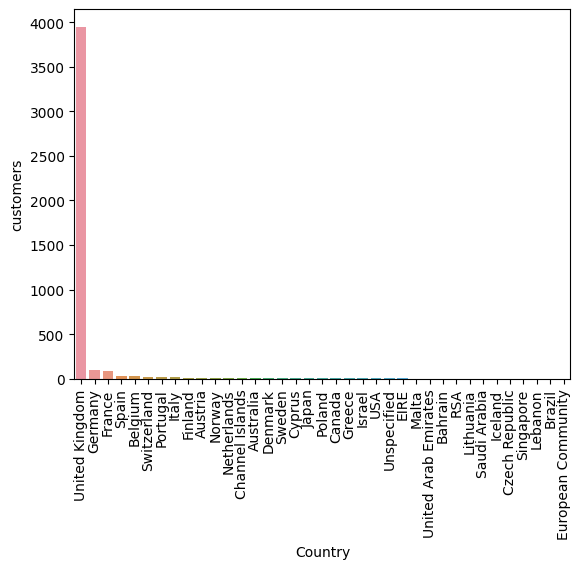

<Figure size 1200x1000 with 0 Axes>

In [ ]:
sns.barplot(data=countries, x='Country', y='customers')
plt.xticks(rotation=90)
plt.figure(figsize=(12, 10))

# Task 4

Следующая задача – посмотреть на динамику изменения числа активных пользователей в месяц в Великобритании, Австралии и Нидерландах. Полученная вами результирующая таблица должна иметь вид: страна - число уникальных пользователей за определённый месяц.

MAU (monthly active users) – число уникальных пользователей за месяц. Активные пользователи – те, кто сделал хотя бы один заказ за выбранный промежуток времени (месяц).
В качестве ответа укажите наименьшее число пользователей за февраль 2011. 



In [ ]:
sql = '''select
  Country,
  count(distinct(CustomerID)) as customers,
  toStartOfMonth(cast(InvoiceDate as Date)) as date
from
    retail
where Country in ('United Kingdom', 'Australia', 'Netherlands')
group by Country, date
order by date'''

In [ ]:
select(sql)

# Task 5

Как вы могли заметить, график с предыдущего шага получается не очень информативным для 2 из 3 стран. Давайте посмотрим на динамику изменения числа активных пользователей в месяц уже для всех стран, кроме Великобритании. 

В каких месяцах число активных пользователей во Франции было больше, чем в Германии?

NB! Фильтровать по Quantity здесь не нужно. 

In [ ]:
sql = '''select
  Country,
  count(distinct(CustomerID)) as customers,
  toStartOfMonth(cast(InvoiceDate as Date)) as date
from
    retail
where Country != 'United Kingdom'
group by Country, date
order by date'''

In [ ]:
task_5_df = select(sql)
task_5_df.head()

,Country,customers,date
0,Spain,4,2010-12-01
1,France,15,2010-12-01
2,Israel,1,2010-12-01
3,Netherlands,2,2010-12-01
4,Belgium,4,2010-12-01


<Axes: xlabel='date', ylabel='customers'>

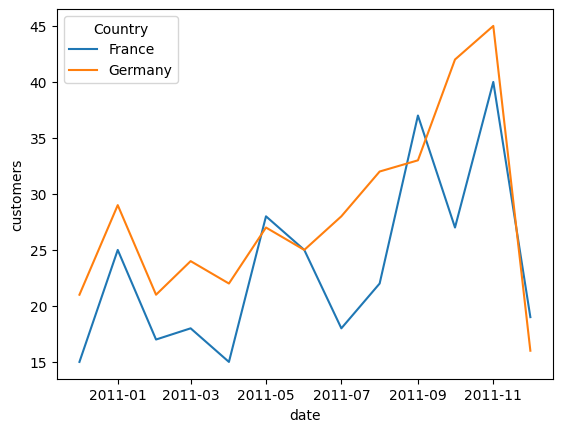

In [ ]:
sns.lineplot(data=task_5_df.query('Country in ("Germany", "France")'), x='date', y='customers', hue='Country')

# Task 6

Теперь проанализируем сами заказы. Посчитайте среднюю сумму заказа (AOV – average order value) в каждой из стран.

Обратите внимание, что пользователь может добавить несколько одинаковых товаров в один заказ, и для подсчета суммы каждого заказа можно создать столбец TotalPrice, в котором будет храниться цена, которую пользователь заплатил, например, за три упаковки чая.

Далее для каждого заказа нужно просуммировать полученную колонку, а затем сгруппировать данные по странам и посчитать среднюю сумму заказа в каждой из них.

Визуализируйте результат. Из представленных вариантов ответа выберите страны, входящие в топ-3 по величине средней суммы заказа.

NB! В таблице есть отрицательные значения Quantity, что соответствует отмененным заказам. Их в расчет AOV включать не нужно. 

In [ ]:
sql = '''SELECT
avg(TotalPrice) as avg_total_price,
Country
from
(SELECT 
    SUM(Quantity * cast(UnitPrice as Float64)) as TotalPrice,
    InvoiceNo, 
    Country
from 
    retail
where Quantity >= 0
group by
InvoiceNo,
Country)

GROUP BY
  Country
ORDER BY
  avg_total_price desc'''


In [ ]:
task_6_df = select(sql)
task_6_df.head()

,avg_total_price,Country
0,3039.898571,Singapore
1,3004.698316,Netherlands
2,2430.198421,Australia
3,1969.282632,Japan
4,1693.880000,Lebanon


<Figure size 1200x1000 with 0 Axes>

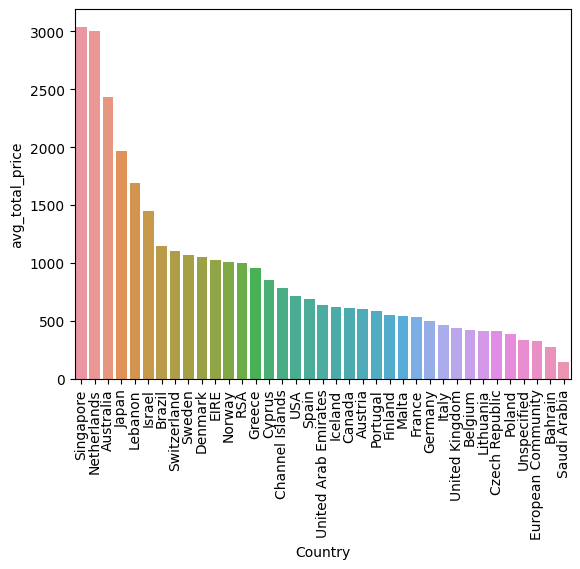

<Figure size 1200x1000 with 0 Axes>

In [ ]:
sns.barplot(data=task_6_df, x='Country', y='avg_total_price')
plt.xticks(rotation=90)
plt.figure(figsize=(12, 10))

# Task 7

Как изменялась средняя сумма заказа в разных странах по месяцам?

Предположим, нас интересует динамика в следующих странах: United Kingdom, Germany, France, Spain, Netherlands, Belgium, Switzerland, Portugal, Australia, USA. Визуализируйте результат и выберите верные утверждения.

In [ ]:
sql = '''SELECT
avg(TotalPrice) as avg_total_price,
Country,
toStartOfMonth(cast(date as Date)) as date
from
(SELECT 
    SUM(Quantity * cast(UnitPrice as Float64)) as TotalPrice,
    InvoiceNo, 
    Country,
    toStartOfMonth(cast(InvoiceDate as Date)) as date
from 
    retail
where Quantity >= 0
group by
InvoiceNo,
Country,
date)
Where Country in ('United Kingdom', 'Germany', 'France', 'Spain', 'Netherlands', 'Belgium', 'Switzerland', 'Portugal', 'Australia', 'USA')
GROUP BY
  Country, date
ORDER BY
  avg_total_price desc'''

In [ ]:
task_7_df = select(sql)
task_7_df

,avg_total_price,Country,date
0,11244.60000,Australia,2011-08-01
1,6296.94250,Australia,2011-06-01
2,5741.33000,Australia,2011-03-01
3,5322.23200,Netherlands,2011-01-01
4,5040.97625,Netherlands,2011-08-01
...,...,...,...
113,294.82000,Portugal,2011-06-01
114,272.63375,Belgium,2011-02-01
115,264.49000,Portugal,2011-11-01
116,158.10500,Spain,2011-12-01


(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15034.0, 0, '2011-03'),
  Text(15095.0, 0, '2011-05'),
  Text(15156.0, 0, '2011-07'),
  Text(15218.0, 0, '2011-09'),
  Text(15279.0, 0, '2011-11')])

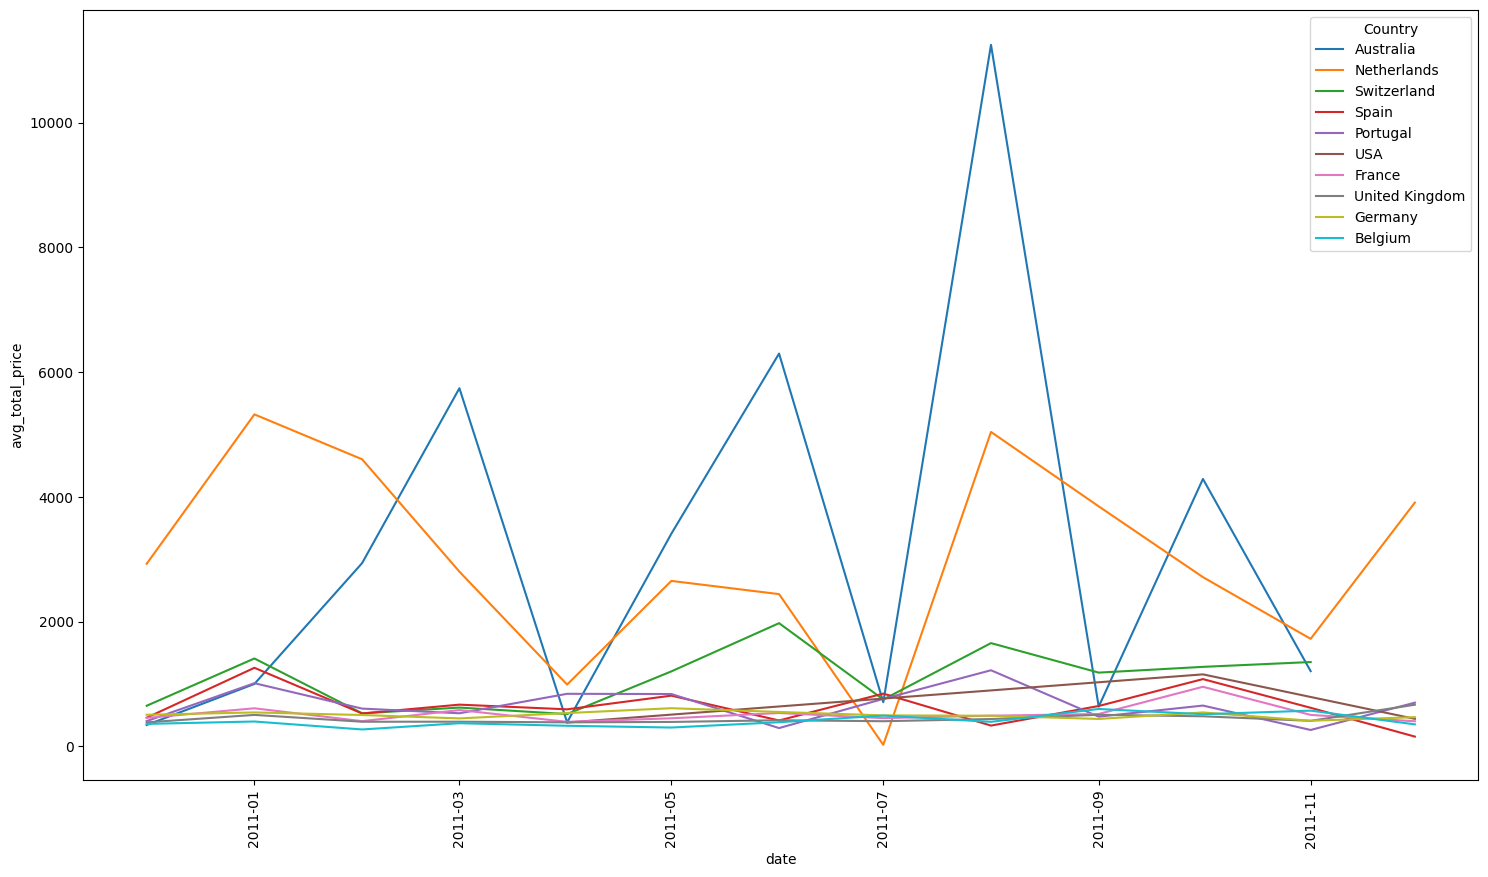

In [ ]:
plt.figure(figsize=(18, 10))
sns.lineplot(data=task_7_df, x='date', y='avg_total_price', hue='Country')
plt.xticks(rotation=90)


# Task 8

Сколько товаров пользователи обычно добавляют в корзину? Посчитайте среднее количество товаров, добавленных в корзину, с разбивкой по странам. 

В качестве ответа укажите среднее число товаров в заказе среди пользователей в Канаде (Canada). Разделитель - точка.

In [ ]:
sql = '''
SELECT
  AVG(sum) as avg_sum,
  Country
FROM
(
SELECT
  sum(Quantity) as sum,
  InvoiceNo,
  Country
from 
    retail
where Quantity >= 0
GROUP BY
  Country, InvoiceNo
)
group by
Country
order by avg_sum desc'''

In [ ]:
select(sql)

,avg_sum,Country
0,2115.126316,Netherlands
1,1477.350877,Australia
2,1369.263158,Japan
3,1002.305556,Sweden
4,809.200000,Israel
5,748.714286,Singapore
6,589.862745,Switzerland
7,540.480769,EIRE
8,537.166667,Norway
9,491.600000,USA


# Task 9

Возможно, результат на предыдущем шаге показался вам странным, особенно если соотнести средний размер корзины с числом уникальных пользователей в некоторых странах. 

Посмотрим на Нидерланды (Netherlands) более подробно. Сгруппируйте данные по пользователям и посмотрите, кто купил наибольшее число товаров. В ответе укажите идентификатор данного пользователя. 

In [ ]:
sql = '''
SELECT
  max(sum) as max_sum,
  CustomerID
FROM
(
SELECT
  sum(Quantity) as sum,
  InvoiceNo,
  CustomerID
from 
    retail
where Quantity >= 0
and 
Country = 'Netherlands'
GROUP BY
  CustomerID, InvoiceNo
)
group by
CustomerID
order by max_sum desc'''

In [ ]:
select(sql)

,max_sum,CustomerID
0,14730,14646
1,353,12759
2,329,12775
3,314,12802
4,212,12778
5,166,12790
6,145,12787
7,97,12791
8,4,12789


# Task 10

Один из пользователей добавил к себе в корзину почти 200 тысяч товаров. Не кажется ли это подозрительным? Изучите, что именно он покупает, посмотрите на количество товаров в каждом заказе, итоговые суммы. Подумайте, кто или что это может быть 🤔

Когда подумаете, просто введите идентификатор данного пользователя еще раз в поле ниже.

In [ ]:
sql = '''

SELECT 
CustomerID,
Description,
InvoiceNo,
SUM(Quantity * cast(UnitPrice as Float64)) as TotalPrice
 from retail
where CustomerID = 14646
group by CustomerID,
Description,
InvoiceNo
order by InvoiceNo'''



In [ ]:
select(sql)

,CustomerID,Description,InvoiceNo,TotalPrice
0,14646,FUNKY WASHING UP GLOVES ASSORTED,539491,2.10
1,14646,JAM MAKING SET WITH JARS,539491,4.25
2,14646,SET OF 3 CAKE TINS PANTRY DESIGN,539491,9.90
3,14646,POSTAGE,539491,15.00
4,14646,PENCIL CASE LIFE IS BEAUTIFUL,539491,2.95
...,...,...,...,...
2080,14646,POSTAGE,C543388,-45.00
2081,14646,Discount,C563593,-206.40
2082,14646,RAIN PONCHO RETROSPOT,C564899,-93.60
2083,14646,Manual,C564899,-105.60
